# In-Depth Emissions Data Visualization
This notebook loads and visualizes vehicle emissions data generated by SUMO, focusing on the file `sumo_test/vbasic-emissions.xml`. We will parse the XML, extract relevant data, and display it using graphs and charts.

In [1]:
# Import required libraries
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# Parse the SUMO emissions XML file and load into a DataFrame (robust to malformed XML)
emissions_path = os.path.join('sumo_test', 'vbasic-emissions.xml')

def safe_parse_xml(path):
    try:
        tree = ET.parse(path)
        root = tree.getroot()
        return root, None
    except ET.ParseError as e:
        # Try to read up to the last valid closing tag
        with open(path, 'r') as f:
            lines = f.readlines()
        # Find the last line with </timestep> and cut after that
        last_valid = 0
        for i, line in enumerate(lines):
            if '</timestep>' in line:
                last_valid = i
        if last_valid > 0:
            xml_str = ''.join(lines[:last_valid+1]) + '\n</emission-export>'
            try:
                root = ET.fromstring(xml_str)
                return root, 'Partial file loaded (up to last valid timestep).'
            except Exception as e2:
                return None, f'Failed to recover: {e2}'
        return None, f'ParseError: {e}'

root, warn_msg = safe_parse_xml(emissions_path)

records = []
if root is not None:
    for timestep in root.findall('timestep'):
        time = float(timestep.attrib['time'])
        for vehicle in timestep.findall('vehicle'):
            rec = {'time': time}
            rec.update(vehicle.attrib)
            records.append(rec)
    df = pd.DataFrame(records)
    # Convert numeric columns
    for col in ['time', 'CO2', 'CO', 'HC', 'NOx', 'PMx', 'fuel', 'electricity', 'noise', 'waiting', 'pos', 'speed', 'angle', 'x', 'y']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if warn_msg:
        print(warn_msg)
    df.head()
else:
    print('Could not parse XML file.')

Partial file loaded (up to last valid timestep).


## Plotting Total Emissions Over Time
We will now visualize the total CO2, CO, NOx, and fuel consumption over time for all vehicles.

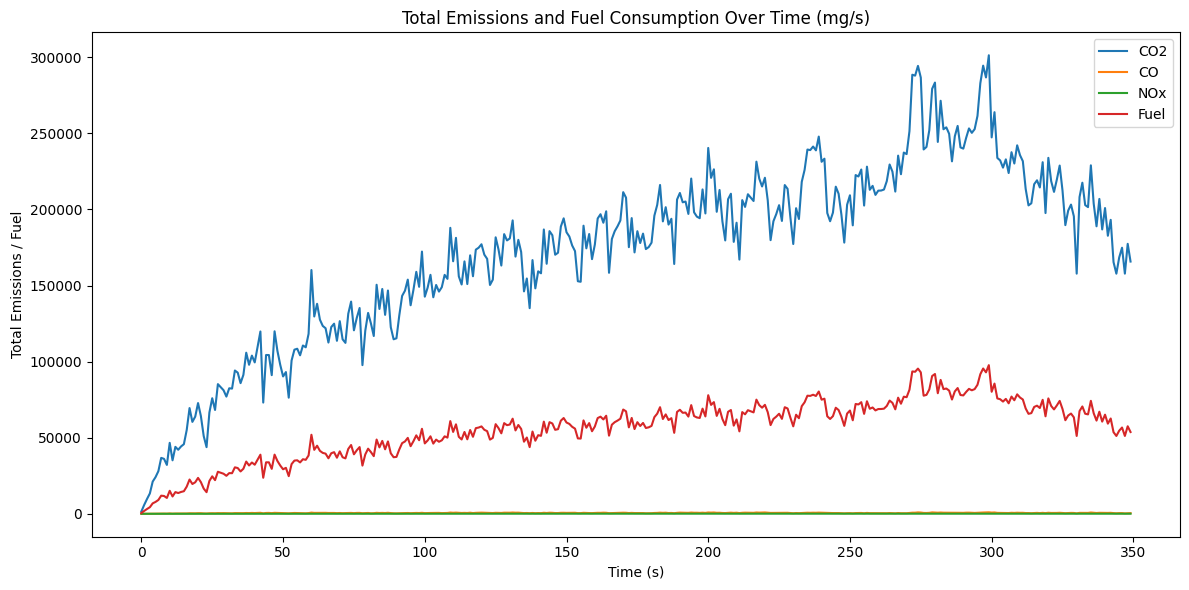

In [8]:
# Plot total emissions over time
emissions = df.groupby('time').agg({'CO2': 'sum', 'CO': 'sum', 'NOx': 'sum', 'fuel': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=emissions, x='time', y='CO2', label='CO2')
sns.lineplot(data=emissions, x='time', y='CO', label='CO')
sns.lineplot(data=emissions, x='time', y='NOx', label='NOx')
sns.lineplot(data=emissions, x='time', y='fuel', label='Fuel')
plt.title('Total Emissions and Fuel Consumption Over Time (mg/s)')
plt.xlabel('Time (s)')
plt.ylabel('Total Emissions / Fuel')
plt.legend()
plt.tight_layout()
plt.show()

## Per-Vehicle Emissions Analysis
Next, let's analyze and visualize emissions for individual vehicles.

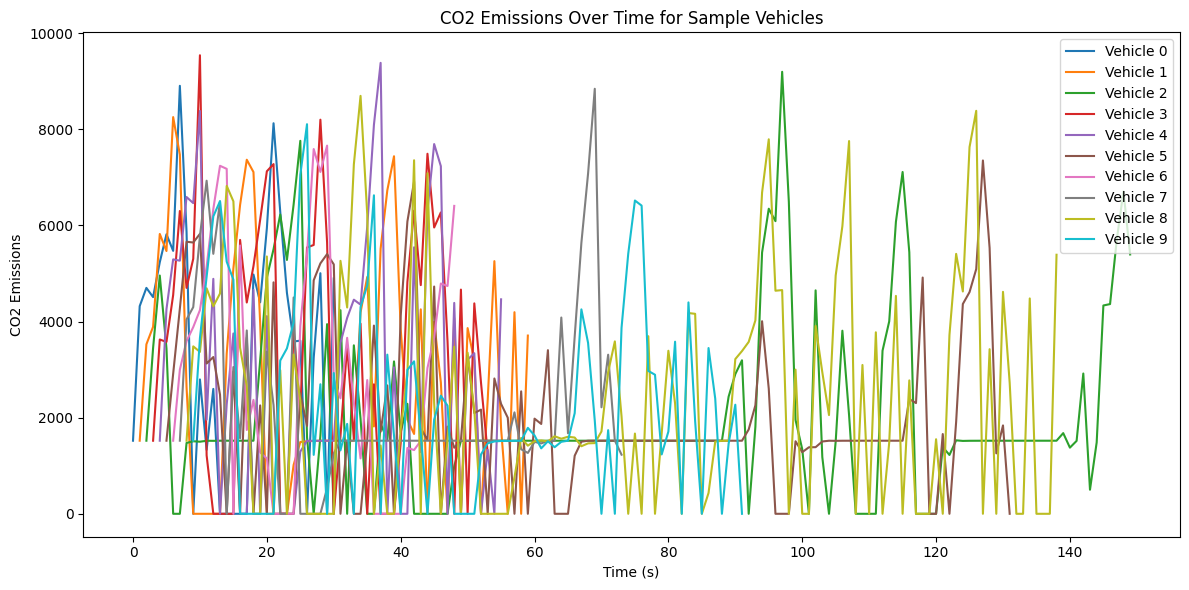

In [27]:
# Plot CO2 emissions over time for a sample of vehicles
sample_vehicles = df['id'].dropna().unique()[:10]  # Take up to 5 vehicles for clarity
plt.figure(figsize=(12, 6))
for vid in sample_vehicles:
    vdata = df[df['id'] == vid]
    plt.plot(vdata['time'], vdata['CO2'], label=f'Vehicle {vid}')
plt.title('CO2 Emissions Over Time for Sample Vehicles')
plt.xlabel('Time (s)')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.tight_layout()
plt.show()

## Emissions Summary Statistics
Let's compute summary statistics for emissions and fuel consumption across all vehicles and timesteps.

In [7]:
# Display summary statistics for emissions and fuel consumption
summary_cols = ['CO2', 'CO', 'NOx', 'fuel']
df[summary_cols].describe()

,CO2,CO,NOx,fuel
count,28690.000000,28690.000000,28690.000000,28690.000000
mean,2105.054078,6.599555,0.726383,682.431419
std,1870.233152,14.461623,0.586833,606.294367
min,0.000000,0.000000,0.000000,0.000000
25%,1450.347500,0.000000,0.610000,470.197500
50%,1521.000000,0.000000,0.610000,493.100000
75%,2806.675000,4.860000,0.840000,909.890000
max,11796.240000,135.710000,4.460000,3824.130000


## Waiting Time Analysis
Let's visualize waiting times for vehicles in the simulation. We'll look at total waiting time per vehicle and waiting time distribution over time.

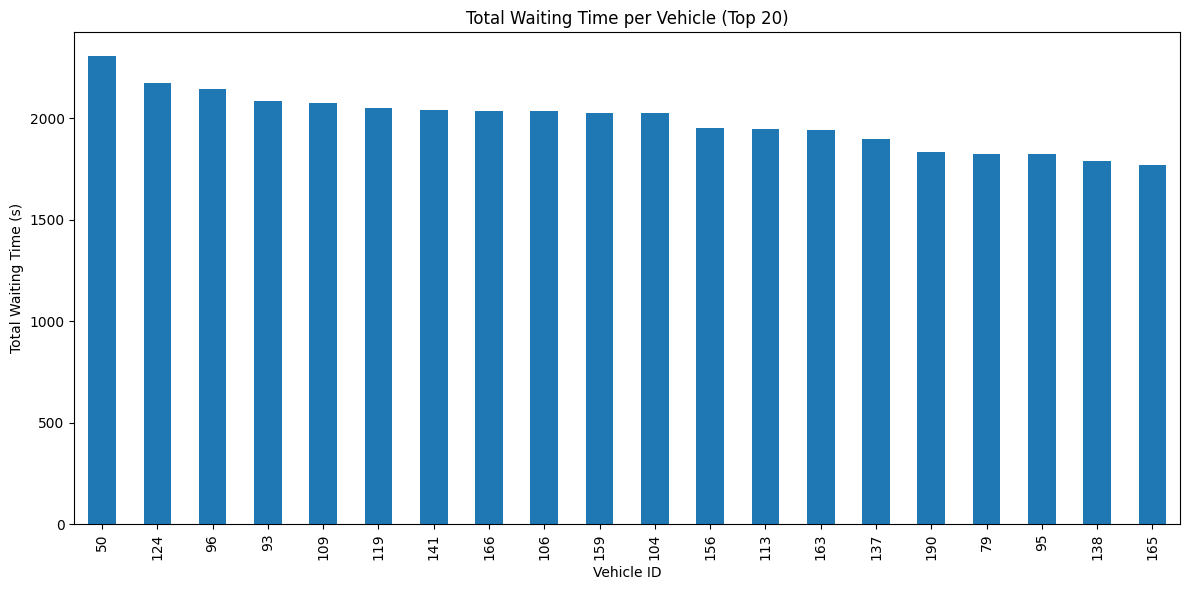

In [12]:
# Plot total waiting time per vehicle
waiting_per_vehicle = df.groupby('id')['waiting'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
waiting_per_vehicle.head(20).plot(kind='bar')
plt.title('Total Waiting Time per Vehicle (Top 20)')
plt.xlabel('Vehicle ID')
plt.ylabel('Total Waiting Time (s)')
plt.tight_layout()
plt.show()

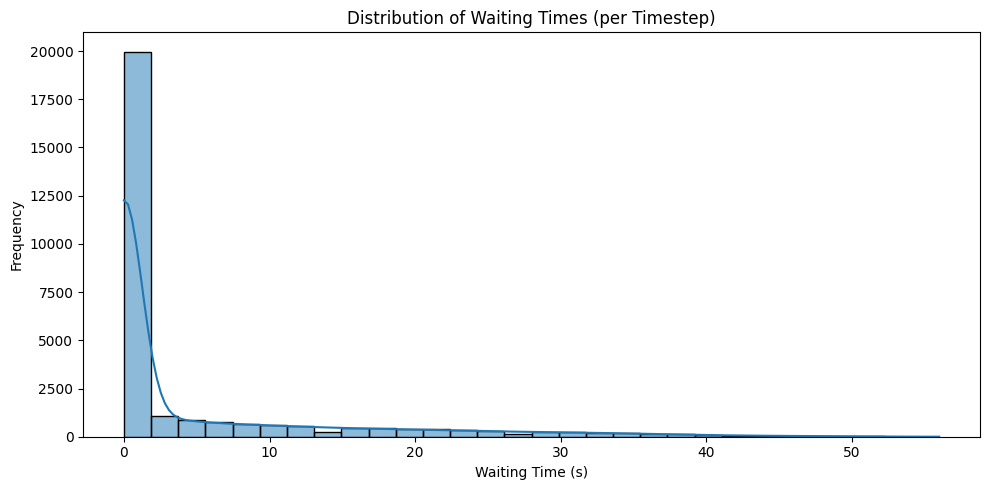

In [13]:
# Plot distribution of waiting times across all vehicles and timesteps
plt.figure(figsize=(10, 5))
sns.histplot(df['waiting'], bins=30, kde=True)
plt.title('Distribution of Waiting Times (per Timestep)')
plt.xlabel('Waiting Time (s)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

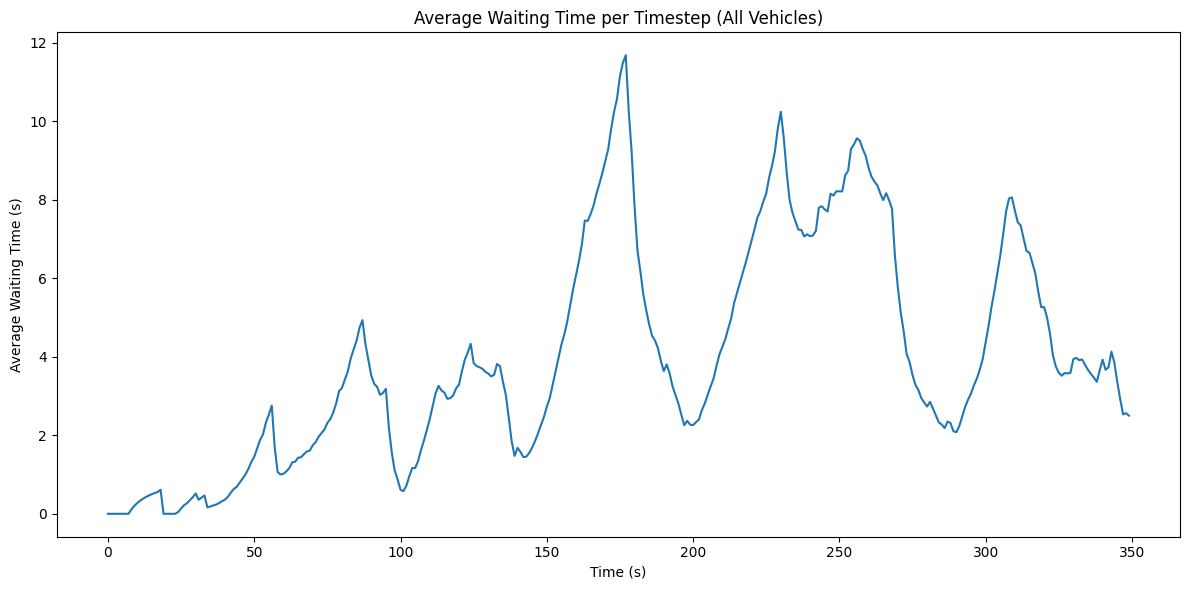

In [14]:
# Plot average waiting time per timestep for the whole simulation
waiting_per_time = df.groupby('time')['waiting'].mean()

plt.figure(figsize=(12, 6))
waiting_per_time.plot()
plt.title('Average Waiting Time per Timestep (All Vehicles)')
plt.xlabel('Time (s)')
plt.ylabel('Average Waiting Time (s)')
plt.tight_layout()
plt.show()

## Next Steps and Further Analysis
- Explore emissions by vehicle type or route if available in the data.
- Visualize spatial distribution of emissions using the x/y coordinates.
- Compare emissions across different simulation runs or configurations.

## Comparing Emissions Across Different Simulation Runs
To compare emissions from different SUMO simulation runs or configurations, you can load multiple emission XML files, aggregate their results, and visualize them side by side. Below is a code scaffold to help you get started.

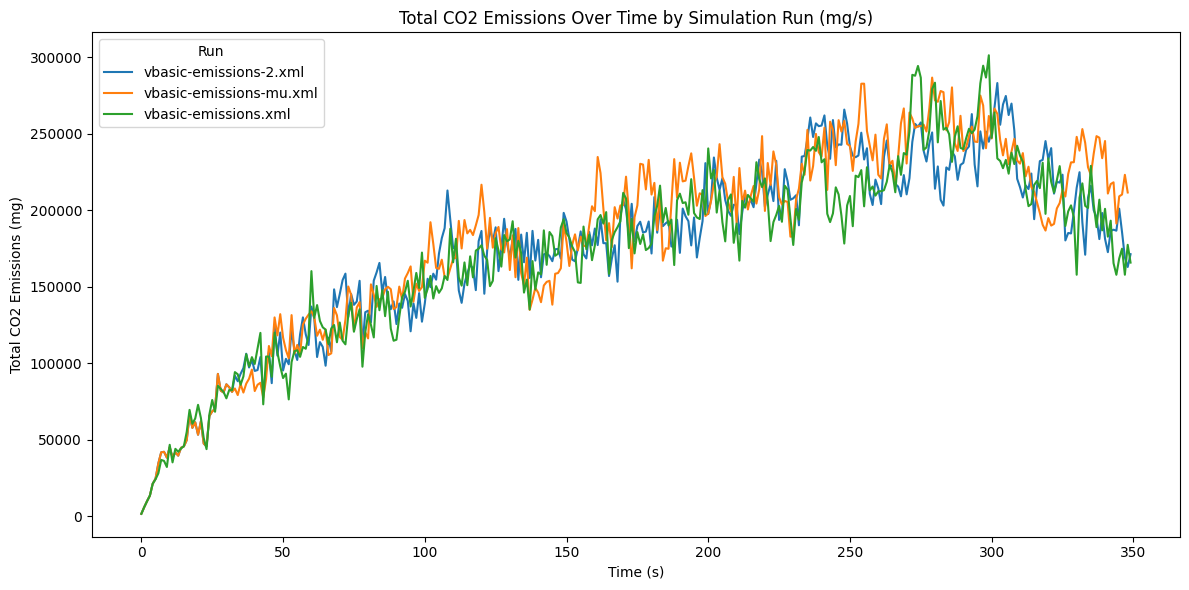

In [33]:
# Example: Compare emissions from multiple simulation runs
import glob

# List your emission XML files here (update the pattern or list as needed)
emission_files = glob.glob('sumo_test/vbasic-emissions*.xml')  # e.g., vbasic-emissions1.xml, vbasic-emissions2.xml, etc.
results = []

def load_emissions(path, label):
    root, warn_msg = safe_parse_xml(path)
    records = []
    if root is not None:
        for timestep in root.findall('timestep'):
            time = float(timestep.attrib['time'])
            for vehicle in timestep.findall('vehicle'):
                rec = {'time': time, 'run': label}
                rec.update(vehicle.attrib)
                records.append(rec)
    return records

# Load all runs into a single DataFrame
for path in emission_files:
    label = os.path.basename(path)
    records = load_emissions(path, label)
    results.extend(records)

df_all = pd.DataFrame(results)
for col in ['time', 'CO2', 'CO', 'NOx', 'fuel'] + ['HC', 'PMx', 'electricity', 'noise', 'waiting', 'pos', 'speed', 'angle', 'x', 'y']:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# Example: Compare total CO2 emissions over time for each run
emissions_compare = df_all.groupby(['run', 'time'])['CO2'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=emissions_compare, x='time', y='CO2', hue='run')
plt.title('Total CO2 Emissions Over Time by Simulation Run (mg/s)')
plt.xlabel('Time (s)')
plt.ylabel('Total CO2 Emissions (mg)')
plt.legend(title='Run')
plt.tight_layout()
plt.show()

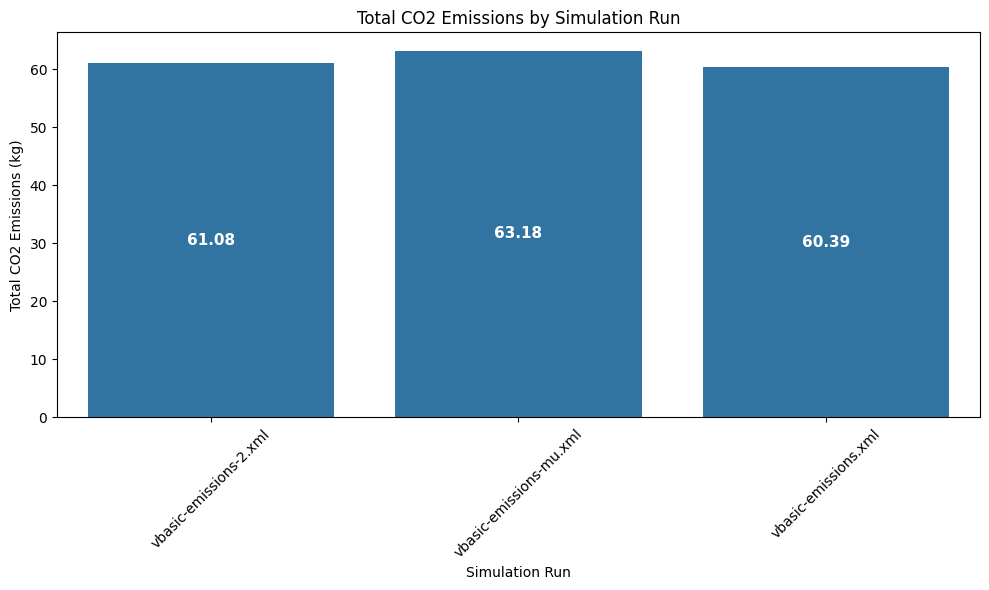

In [34]:
# Compare total CO2 emissions (sum over all timesteps) for each run, in kg
total_co2_per_run = df_all.groupby('run')['CO2'].sum().reset_index()
total_co2_per_run['CO2_kg'] = total_co2_per_run['CO2'] / 1e6

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=total_co2_per_run, x='run', y='CO2_kg')
plt.title('Total CO2 Emissions by Simulation Run')
plt.xlabel('Simulation Run')
plt.ylabel('Total CO2 Emissions (kg)')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels inside the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                ha='center', va='center', color='white', fontsize=11, fontweight='bold')

plt.show()